In [1]:
import scarlet
import galsim
import galsim_compare_tools as gct
from astropy import wcs as WCS
import scipy.stats as scs
import pickle

In [2]:
%pylab inline
#Loading stuffs
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'

HST, EUCLID, WFIRST, HSC, LSST = gct.load_surveys()

cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')

def mad(x):
    return scs.median_absolute_deviation(x)

matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

Populating the interactive namespace from numpy and matplotlib


HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}


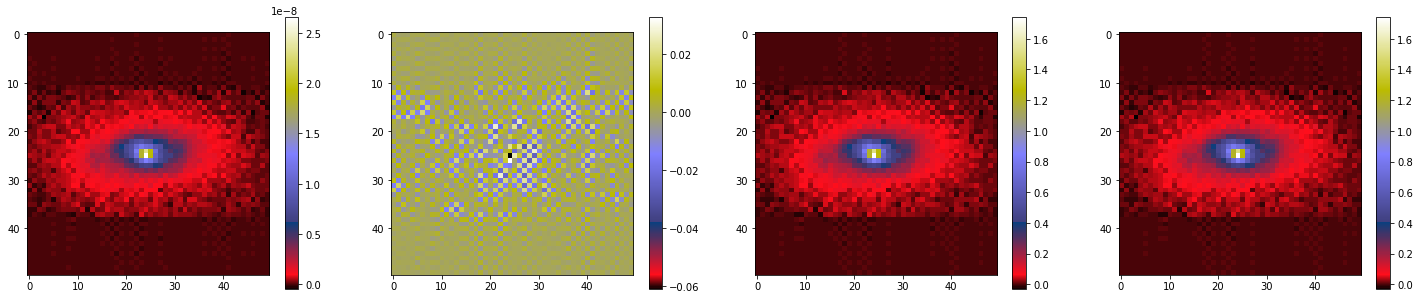

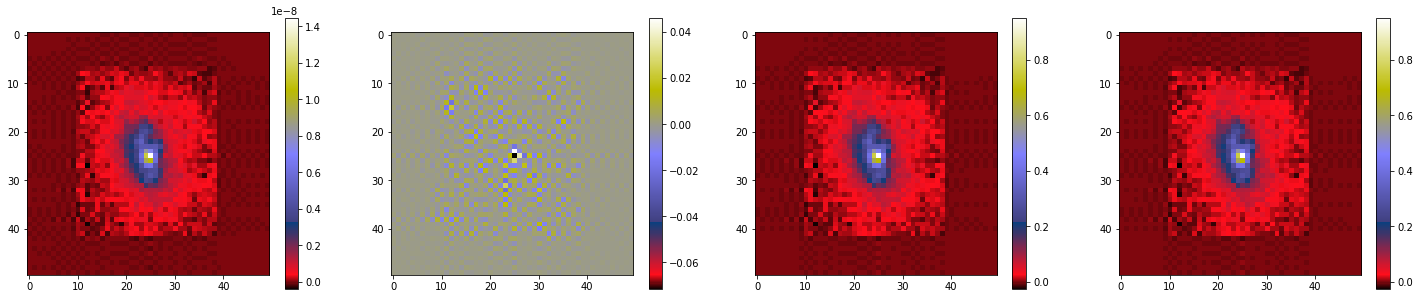

HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}


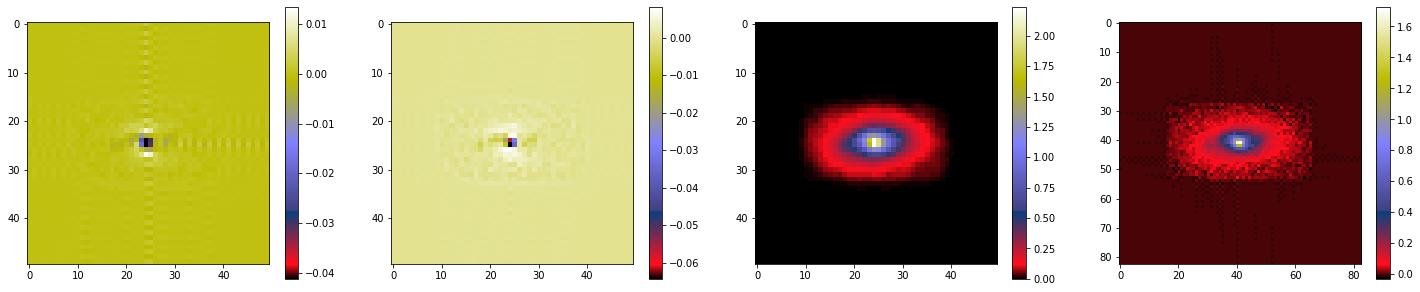

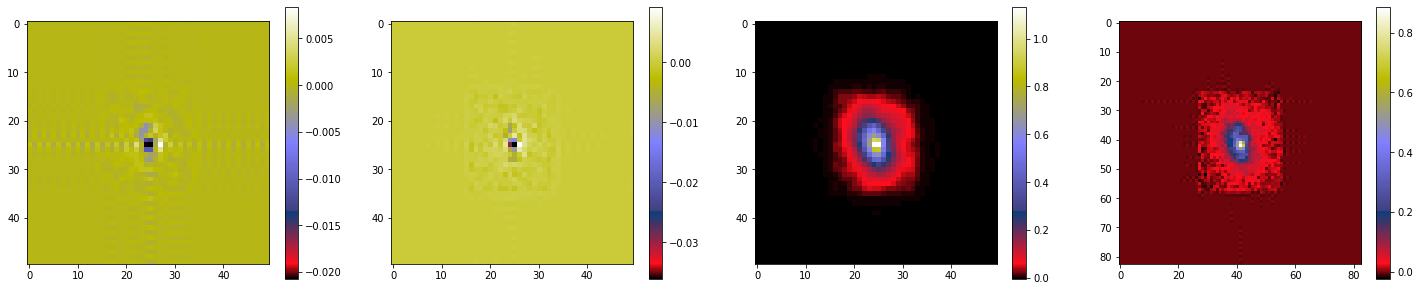

HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}


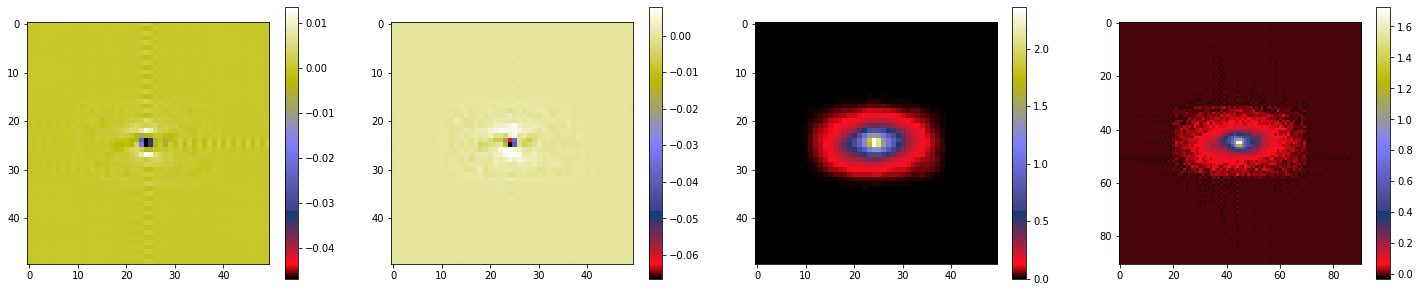

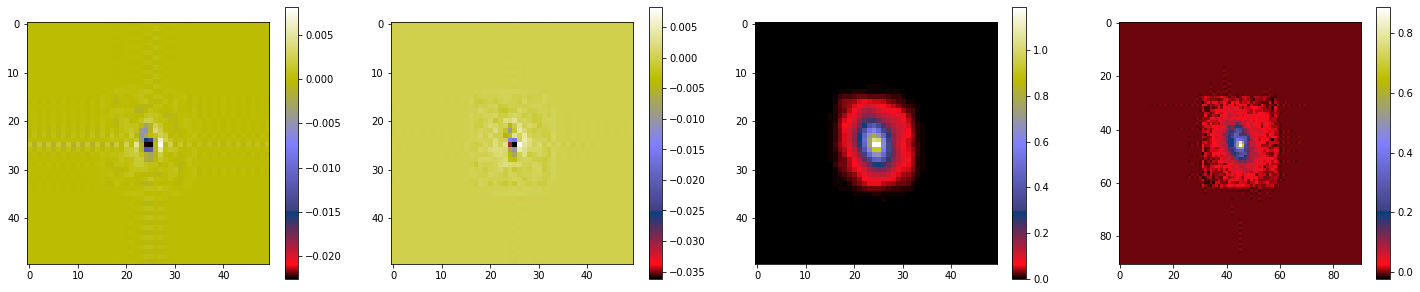

HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}


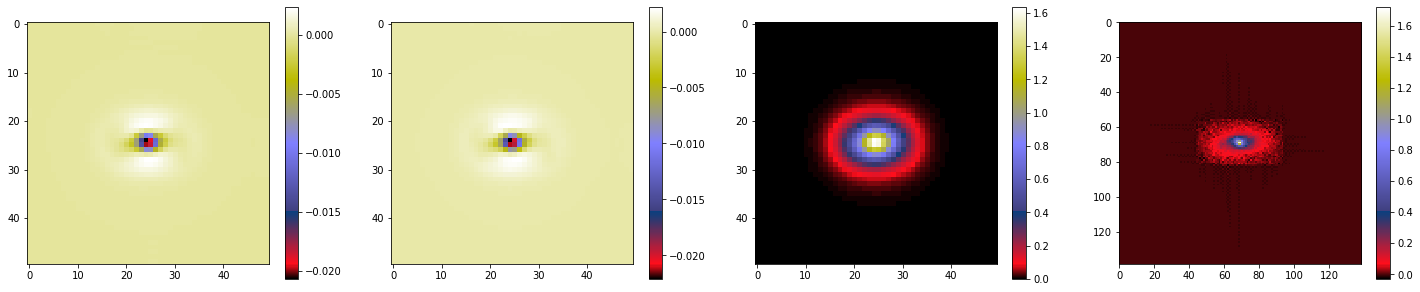

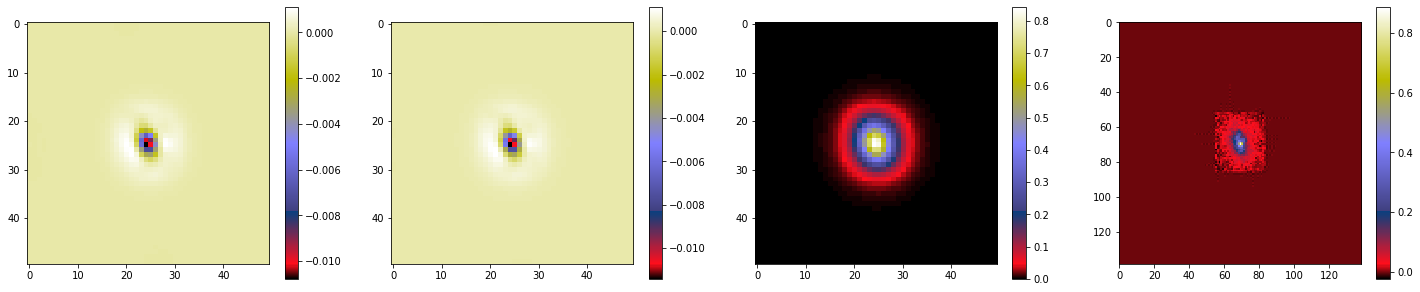

HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


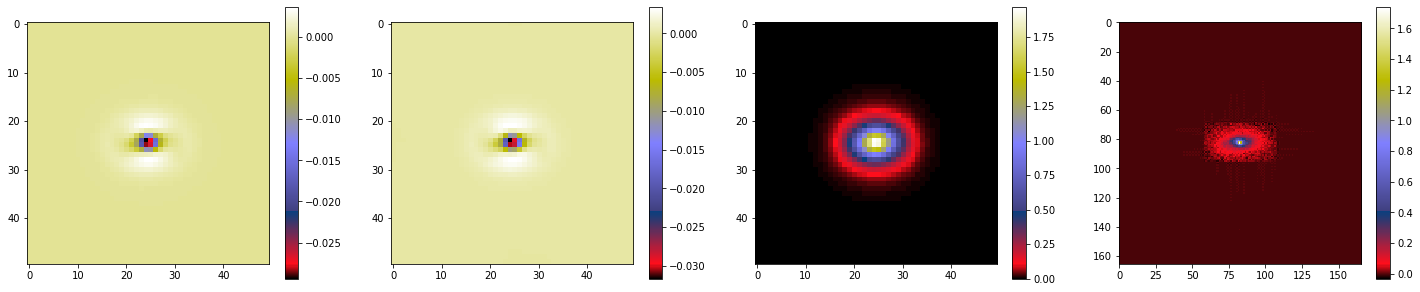

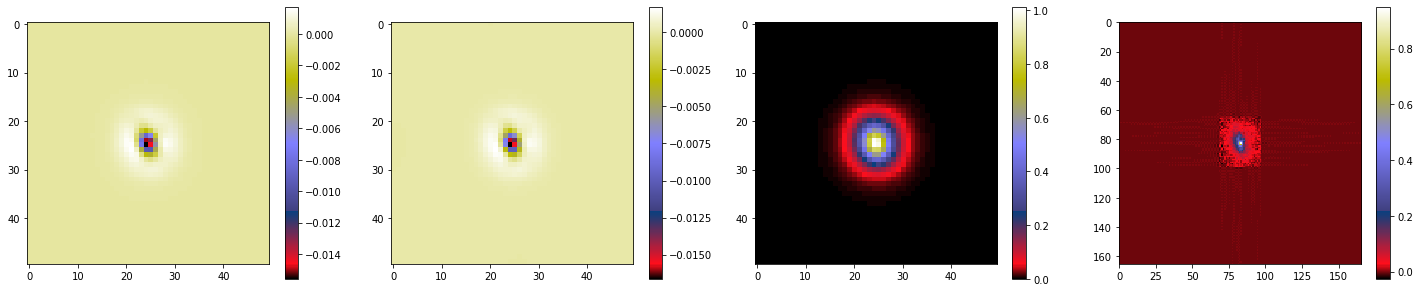

HR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
LR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}


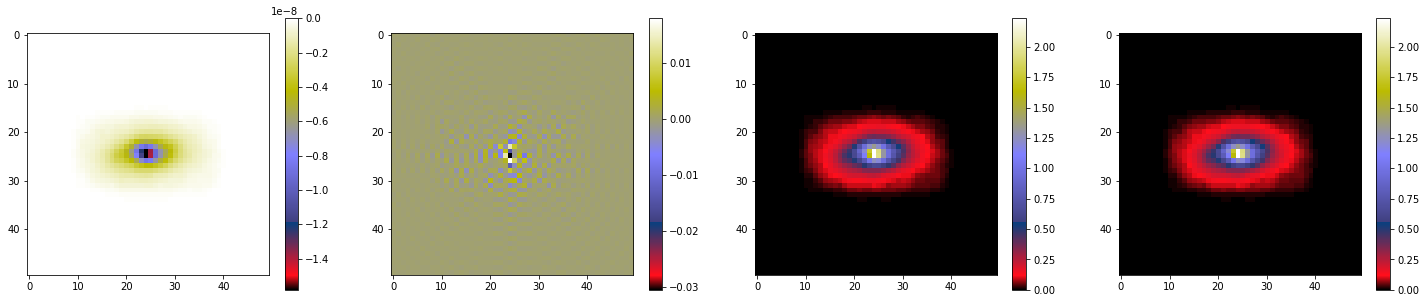

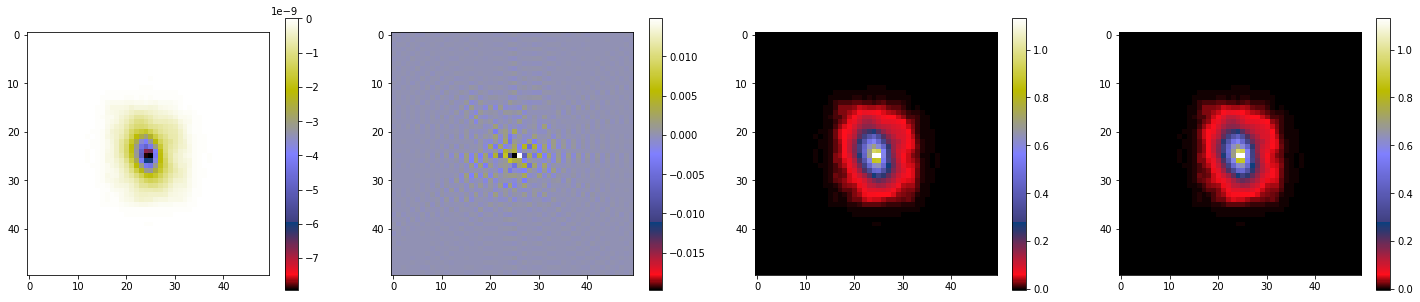

HR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
LR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}


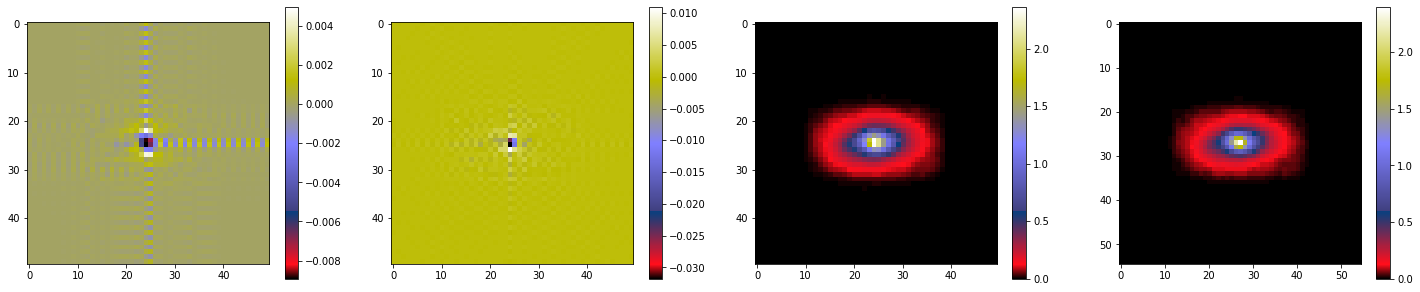

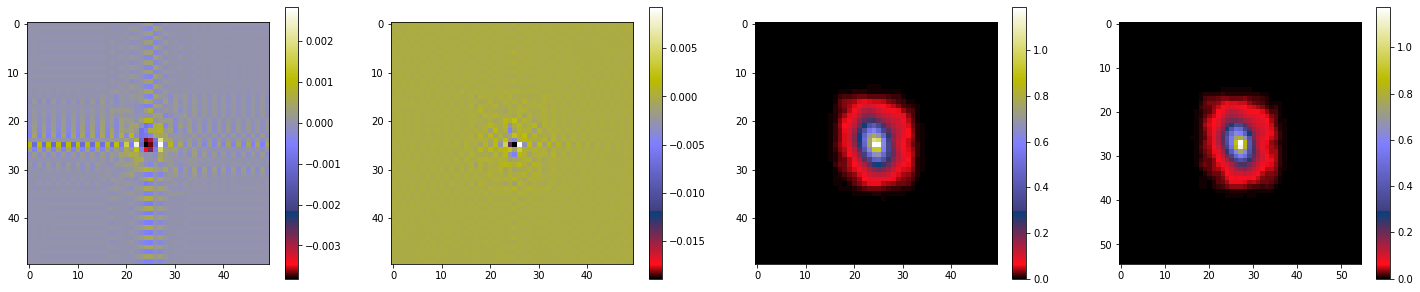

HR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
LR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}


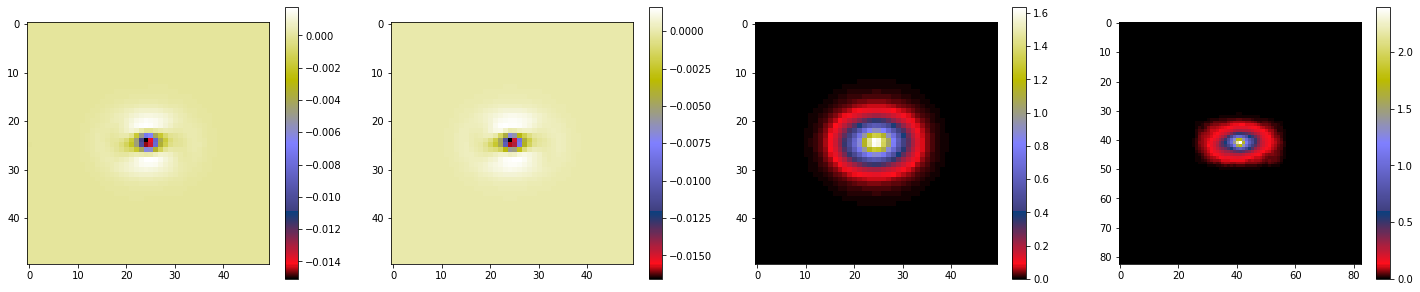

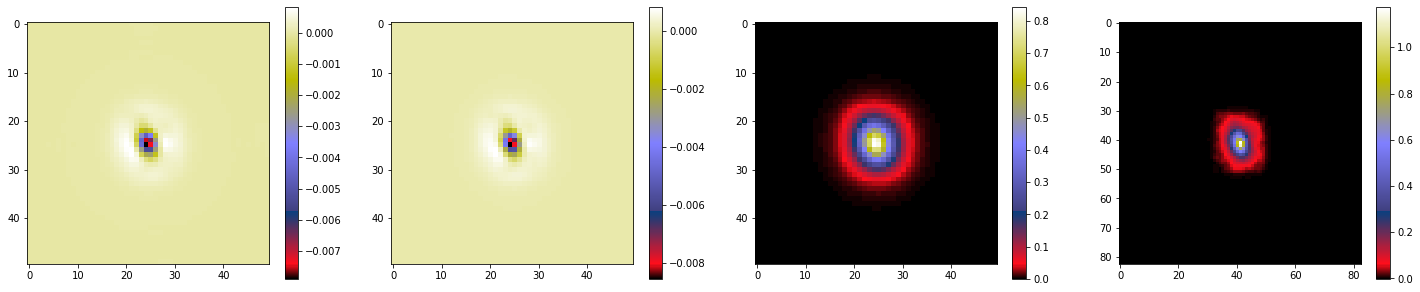

HR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


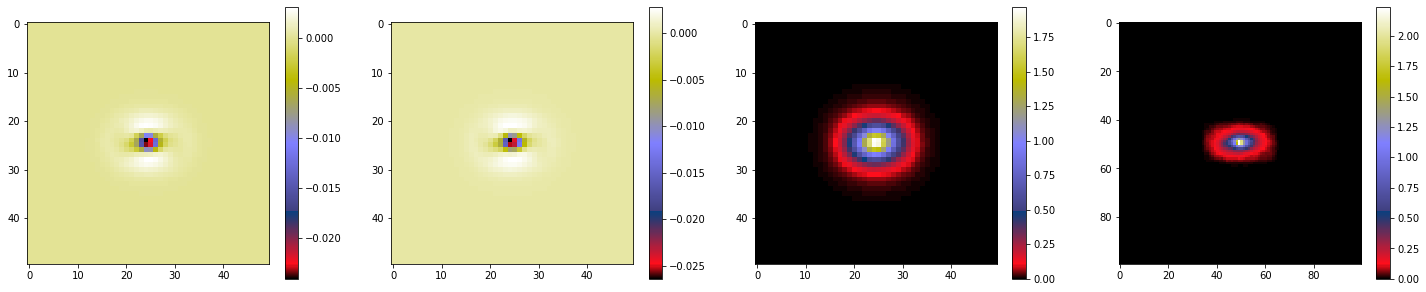

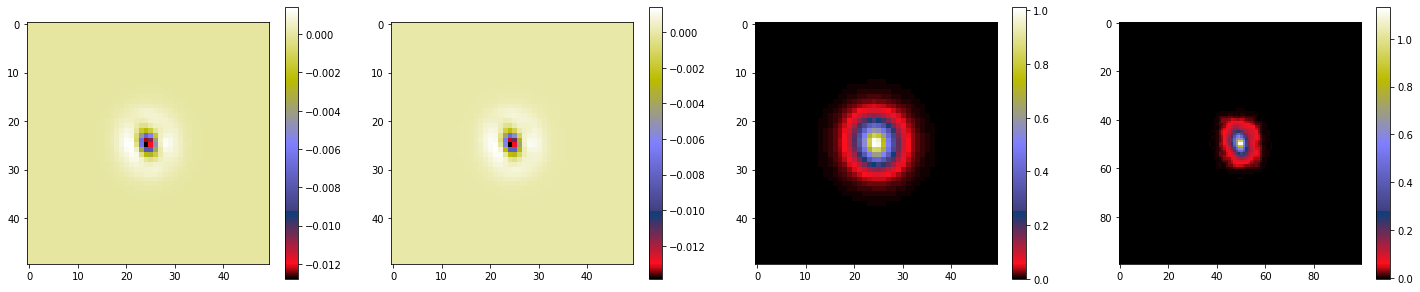

HR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
LR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}


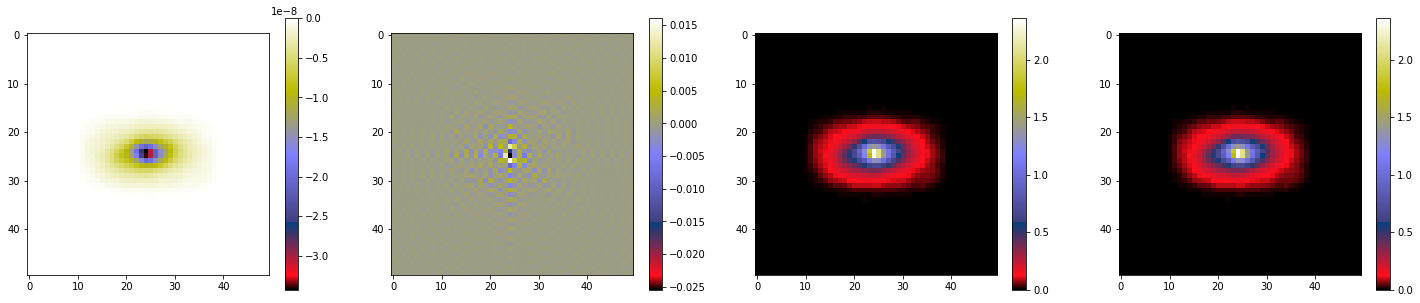

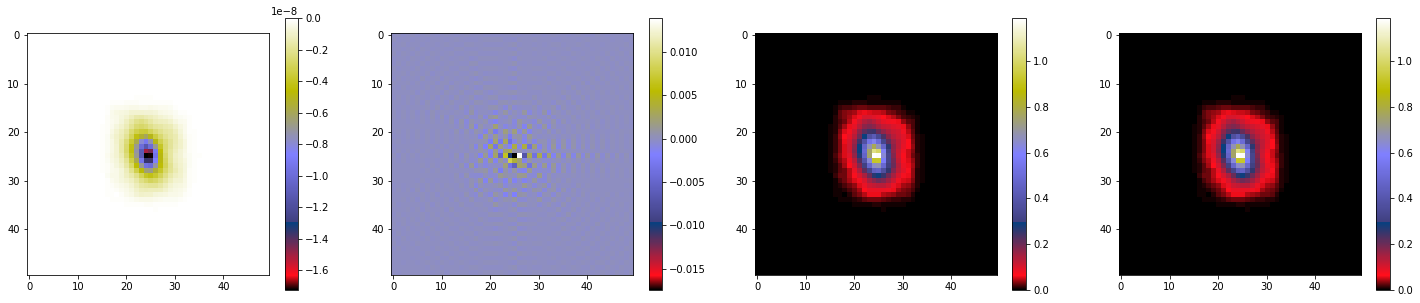

HR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
LR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}


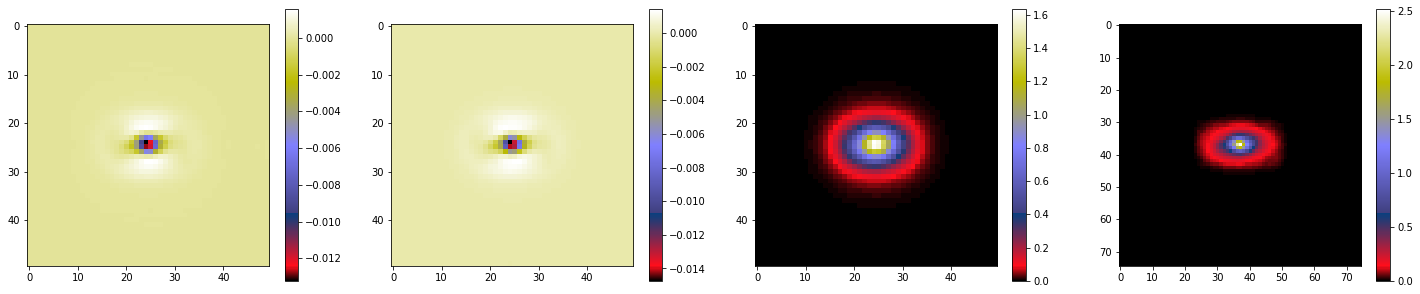

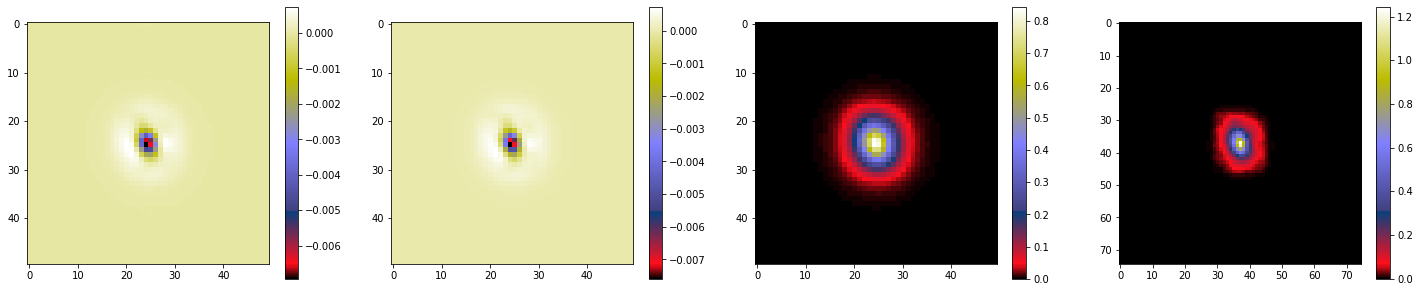

HR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


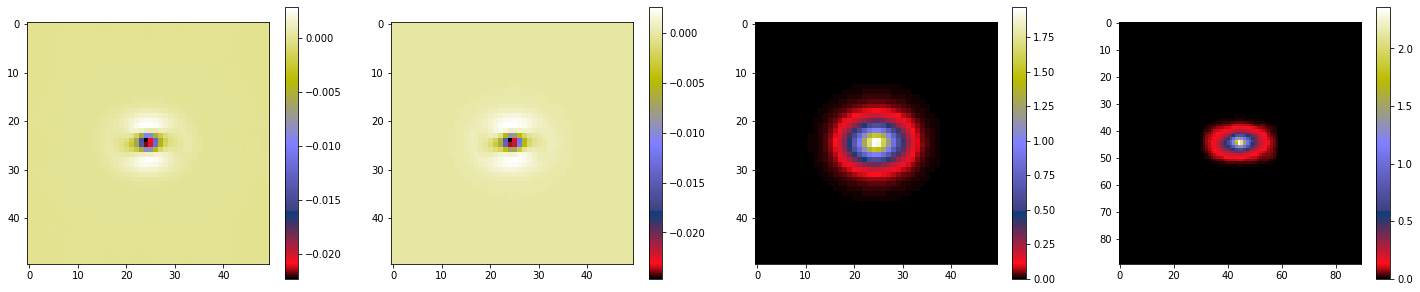

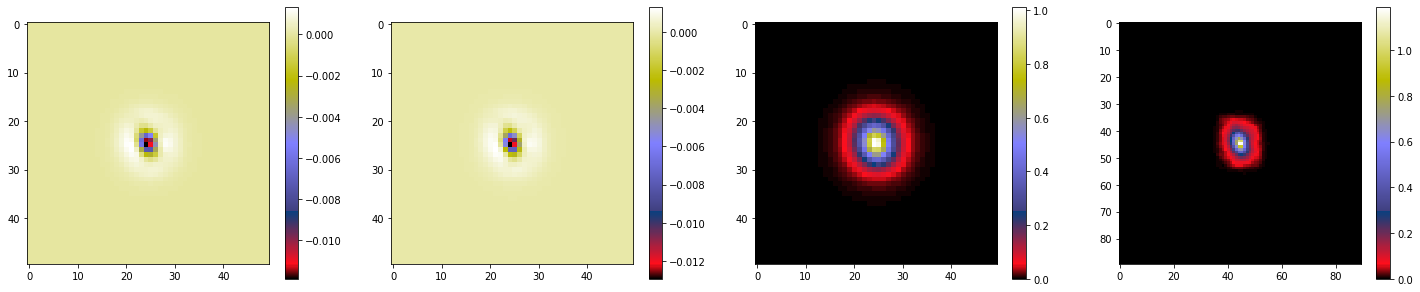

HR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
LR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}


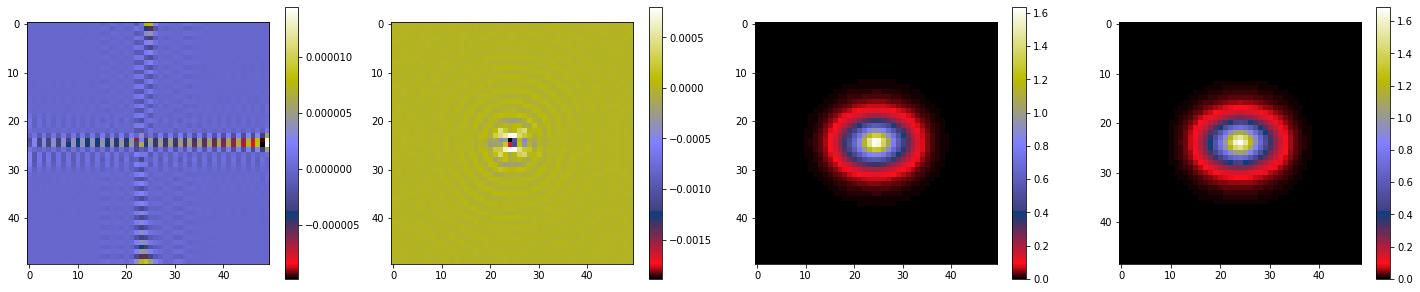

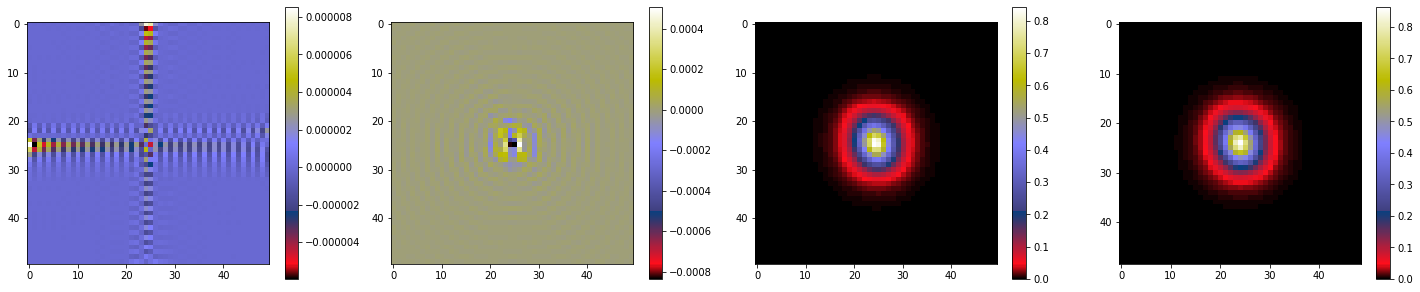

HR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


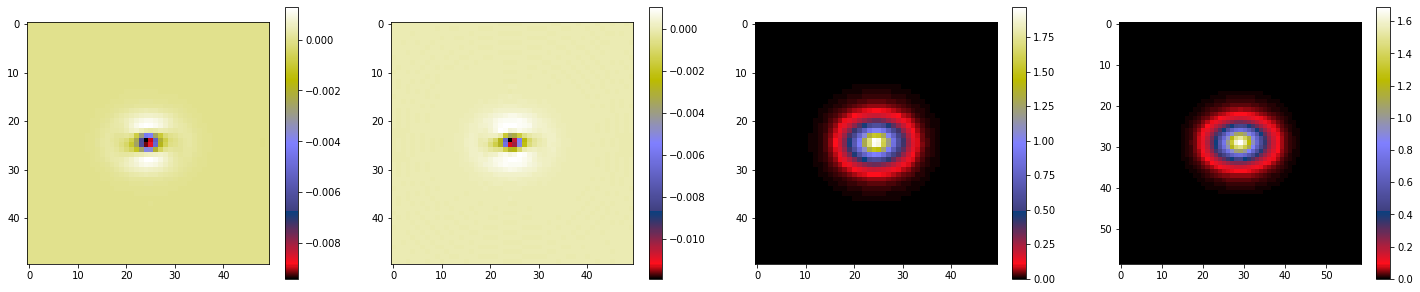

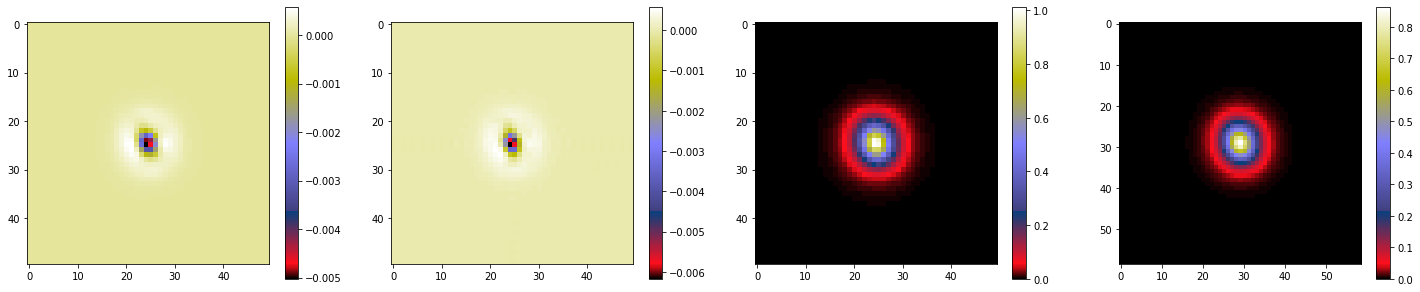

HR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


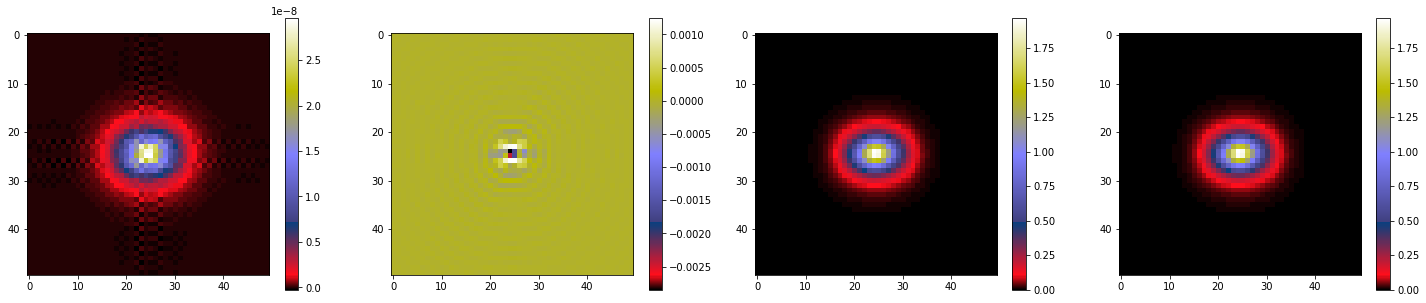

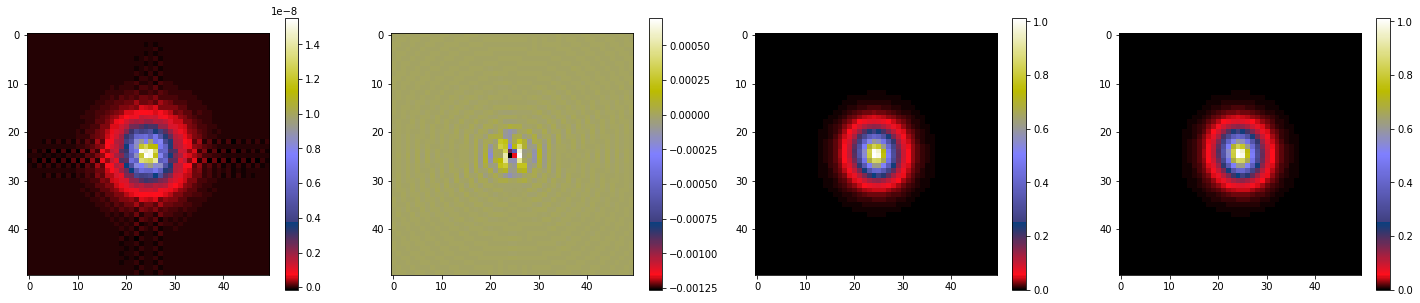

In [3]:
# Shape of the low resolutino images
nlr = 50
# List of surveys
surveys = [HST, EUCLID, WFIRST, HSC, LSST]
# Scarlet-specific channels
channel_hr = ['hr']
channel_lr = ['lr']
channels = channel_lr+channel_hr
# Storrage for the results
reconstructions = {'survey_lr': [], 'survey_hr': [], 'n_hr': [], 'true_flux': [], 'lr_flux': [], 
                   's_flux': [], 'g_flux': [], 's_sdr': [], 'g_sdr': []}
# PSF size (pixels)
npsf = 41

for gg, surveyhr in enumerate(surveys):
    for g, surveylr in enumerate(surveys[gg:]):
        print('HR', surveyhr)
        print('LR', surveylr)
        for i in range(len(cat)):
            nhr = int(nlr*surveylr['pixel']/surveyhr['pixel'])
        
            # Galsim setup:
            data_hr, data_lr, psf_hr, psf_lr, angle = gct.mk_sim(int(i), surveyhr, surveylr, (nhr, nhr), 
                                                                 (nlr, nlr), npsf, cat)

            ## GSO from psf_hr for galsim
            psf_hr_galsim = galsim.InterpolatedImage(galsim.Image(psf_hr[0]), 
                                               scale = surveyhr['pixel'], use_true_center = False)
            ## deconvolution kernel for diff kernel
            deconv = galsim.Deconvolve(psf_hr_galsim)
            ## Interpolation of low resolution psf at high resolution
            psf_lr_hr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                               scale = surveylr['pixel'], use_true_center = False)
            ## Difference kernel from galsim
            diff_gal = galsim.Convolve(deconv, psf_lr_hr)
            diff = diff_gal.drawImage(nx=npsf,ny=npsf, scale=surveyhr['pixel']).array[None, :,:]

            # scarlet setup
            if i == 0:
                obs_lr, obs_hr = gct.setup_scarlet(data_hr, data_lr, psf_hr, psf_lr, channels)

            # Scarlet timing
            scar_rec = obs_lr.render(data_hr.array[None,:,:])
            # Galsim timing
            gal_rec = gct.interp_galsim(data_hr, data_lr, diff_gal, angle, surveyhr['pixel'], surveylr['pixel'])
        
            if i%50 ==0:
                figure(figsize = (25,5))
                subplot(141)
                imshow((scar_rec[0]-data_lr.array))
                colorbar()
                subplot(142)
                imshow((gal_rec.array-data_lr.array))
                colorbar()
                subplot(143)
                imshow((data_lr.array))
                colorbar()
                subplot(144)
                imshow((data_hr.array))
                colorbar()
                show()
            
            reconstructions['survey_lr'].append(surveylr) 
            reconstructions['survey_hr'].append(surveyhr) 
            reconstructions['n_hr'].append(nhr) 
            reconstructions['true_flux'].append((data_hr.array).sum())
            reconstructions['lr_flux'].append((data_lr.array).sum())
            reconstructions['s_flux'].append((scar_rec).sum())
            reconstructions['g_flux'].append((gal_rec.array).sum())
            reconstructions['s_sdr'].append(gct.SDR(data_lr.array,scar_rec))
            reconstructions['g_sdr'].append(gct.SDR(data_lr.array,gal_rec.array))
import pickle   
bfile = open('Precision_npsf='+str(npsf)+'.pkl', 'wb')
pickle.dump(reconstructions, bfile)
bfile.close()

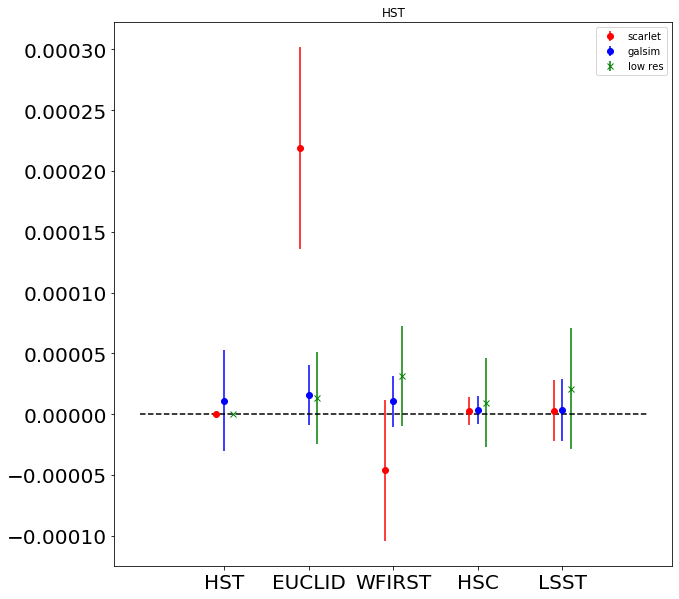

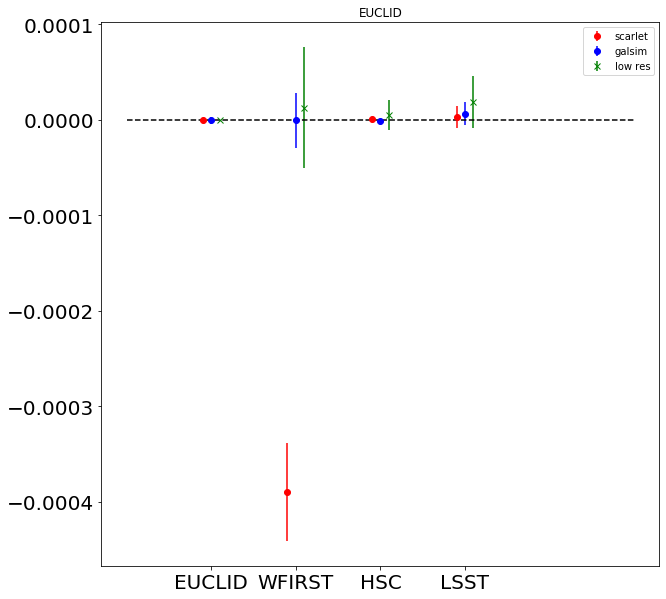

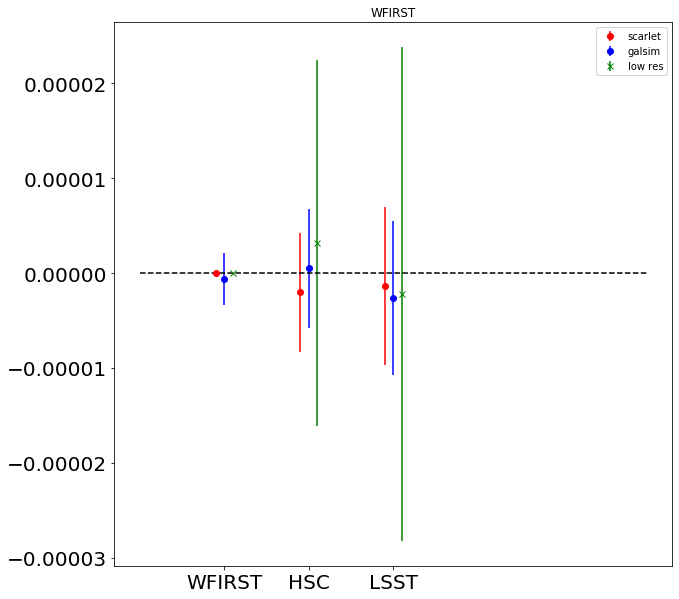

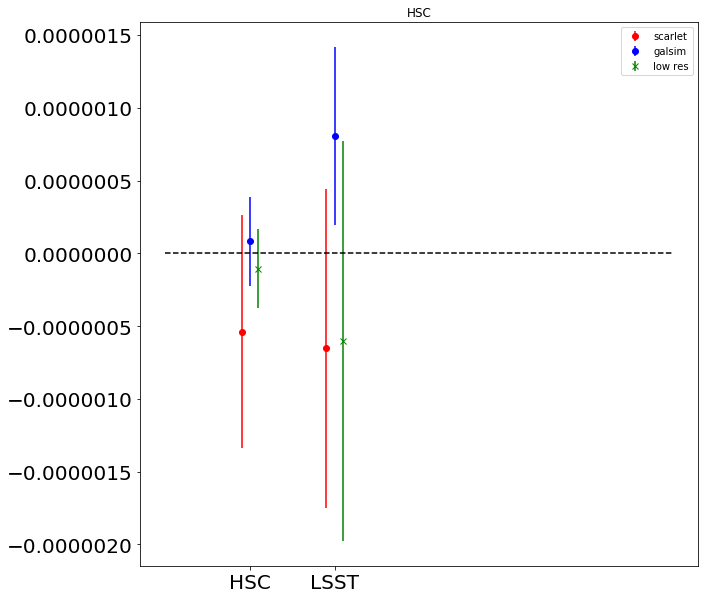

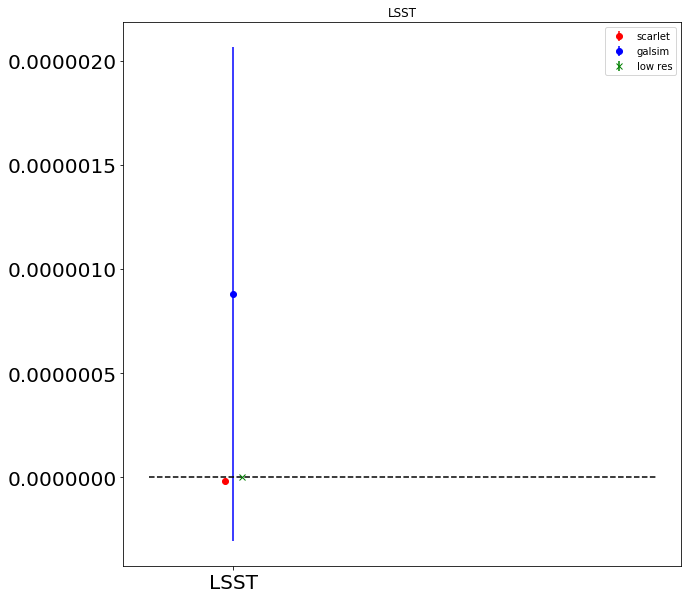

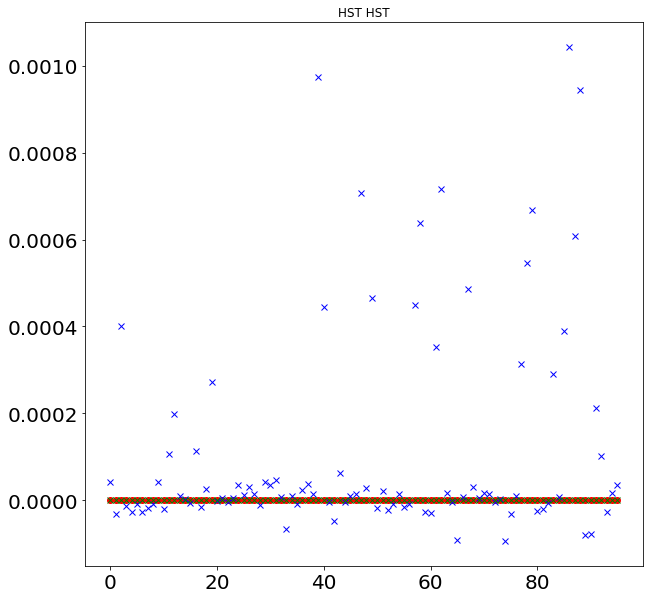

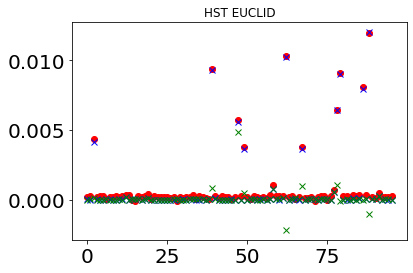

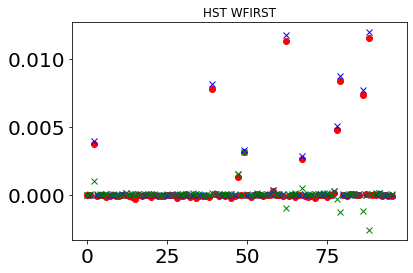

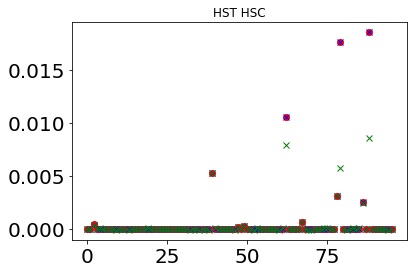

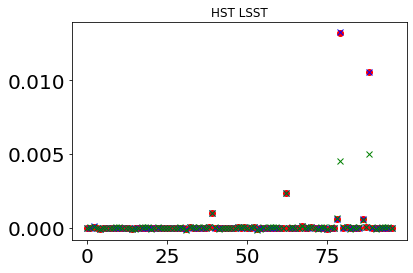

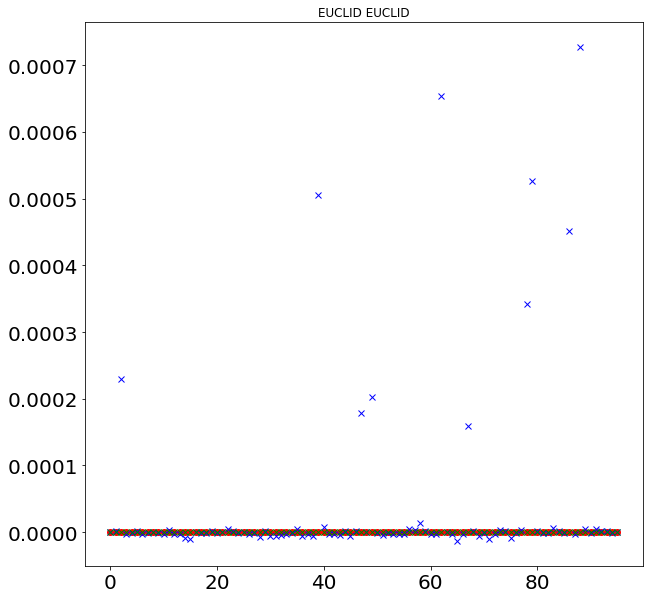

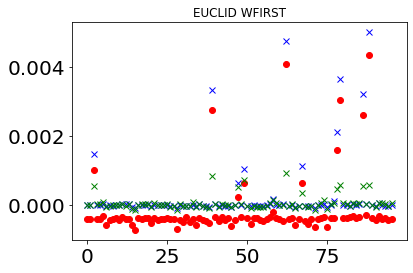

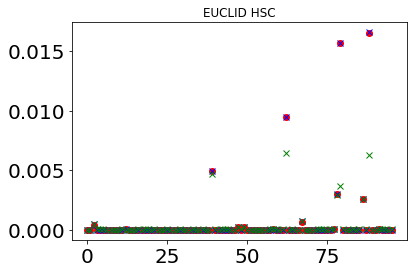

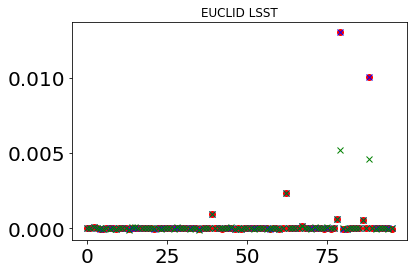

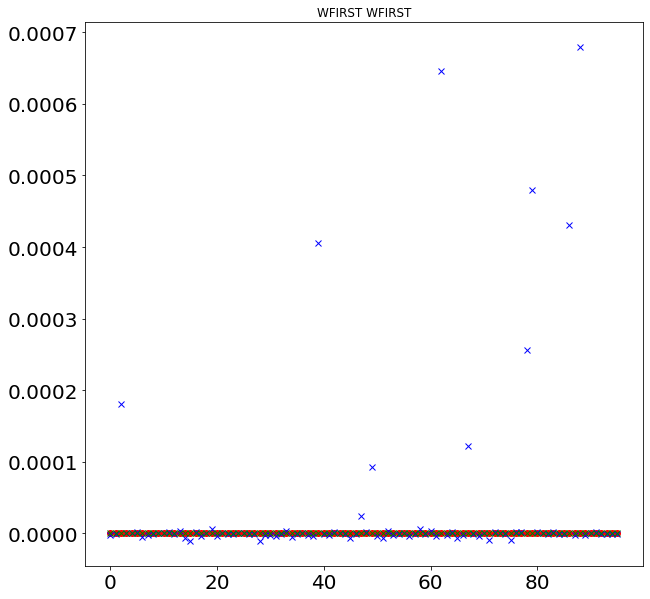

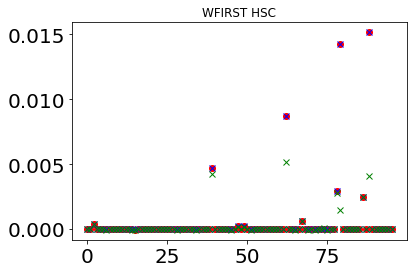

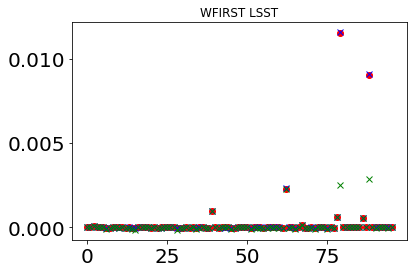

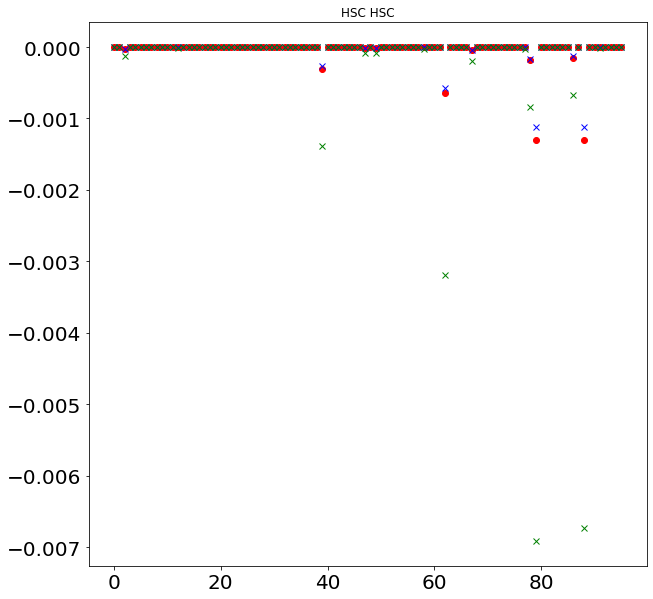

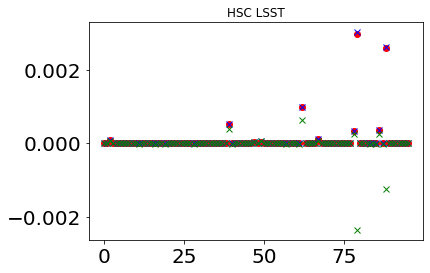

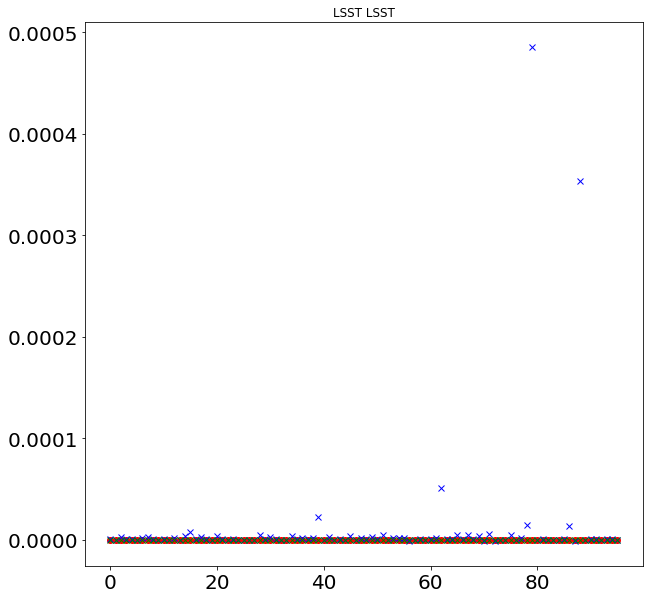

In [32]:

surv_lr = np.array(reconstructions['survey_lr'])
surv_hr = np.array(reconstructions['survey_hr'])
n_hrs = np.array(reconstructions['n_hr'])
truths = np.array(reconstructions['true_flux'])
truth_lr = np.array(reconstructions['lr_flux'])
s_fluxs = np.array(reconstructions['s_flux'])
g_fluxs = np.array(reconstructions['g_flux'])
s_sdr = np.array(reconstructions['s_sdr'])
g_sdr = np.array(reconstructions['g_sdr'])

scar_diff = (truths-s_fluxs)/truths
gal_diff = (truths-g_fluxs)/truths
lr_diff = (truths-truth_lr)/truths

def plot_error_for_survey(x,condition, label = [None, None, None]):
    errorbar(x - 0.1, (np.median(scar_diff[condition])), fmt = 'or', label = label[0], yerr = mad(scar_diff[condition]))
    errorbar(x , (np.median(gal_diff[condition])), fmt = 'ob', label = label[1], yerr = mad(gal_diff[condition]))
    errorbar(x + 0.1, (np.median(lr_diff[condition])), fmt = 'xg', label = label[2], yerr = mad(lr_diff[condition]))
    pass

#figure(figsize = (40,10))
s_matrix = np.zeros((np.size(surveys), np.size(surveys)))
g_matrix = np.zeros((np.size(surveys), np.size(surveys)))
t_matrix = np.zeros((np.size(surveys), np.size(surveys)))
for e, hr in enumerate(surveys):
    figure(figsize = (10,10))
    for ee, lr in enumerate(surveys[e:]):
        s_matrix[e,ee+e] = np.mean(scar_diff[(surv_hr == hr)*(surv_lr == lr)])
        g_matrix[e,ee+e] = np.mean(gal_diff[(surv_hr == hr)*(surv_lr == lr)])
        t_matrix[e,ee+e] = np.mean(lr_diff[(surv_hr == hr)*(surv_lr == lr)])
        if ee == 0:
            plot_error_for_survey(ee+1,(surv_hr == hr)*(surv_lr == lr), label = ['scarlet', 'galsim', 'low res'])
        else:
            
            plot_error_for_survey(ee+1,(surv_hr == hr)*(surv_lr == lr))
    names = [l['name'] for j,l in enumerate(surveys[e:])]
    plt.title(hr['name'])
    plt.xticks((np.arange(ee+1)+1), names)
    plot([0,6], [0,0], '--k')
    legend()
    show()
    
for e, hr in enumerate(surveys):
    figure(figsize = (10,10))
    for ee, lr in enumerate(surveys[e:]):
        plt.title(hr['name'] + ' to ' + lr['name'])
        plt.plot(scar_diff[(surv_hr == hr)*(surv_lr == lr)], 'or')
        plt.plot(gal_diff[(surv_hr == hr)*(surv_lr == lr)], 'xb')
        plt.plot(lr_diff[(surv_hr == hr)*(surv_lr == lr)], 'xg')
        plt.show()

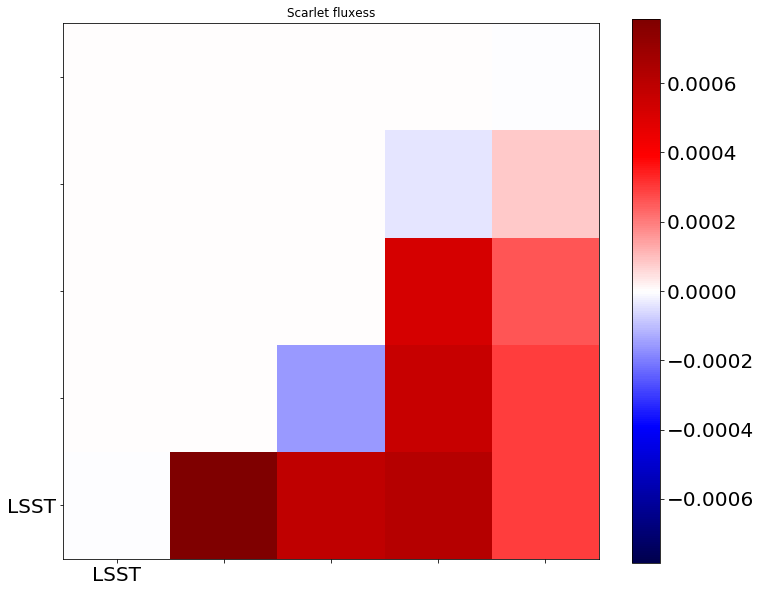

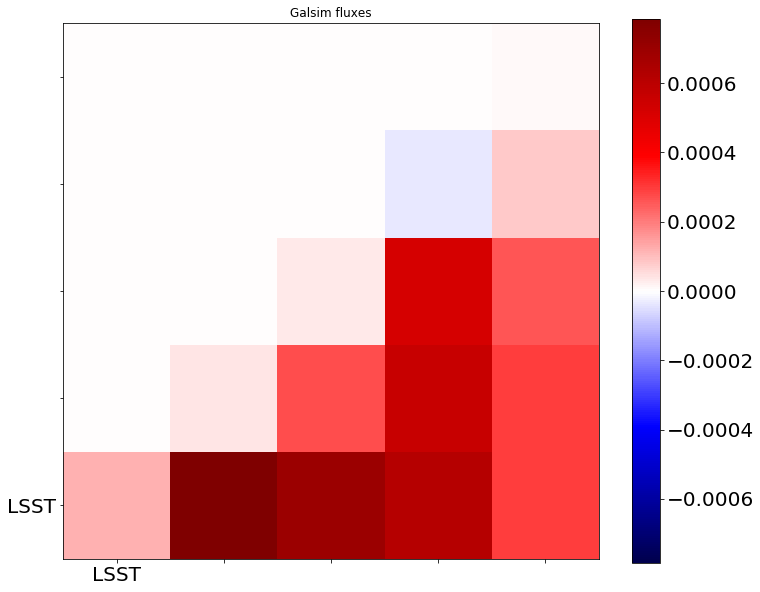

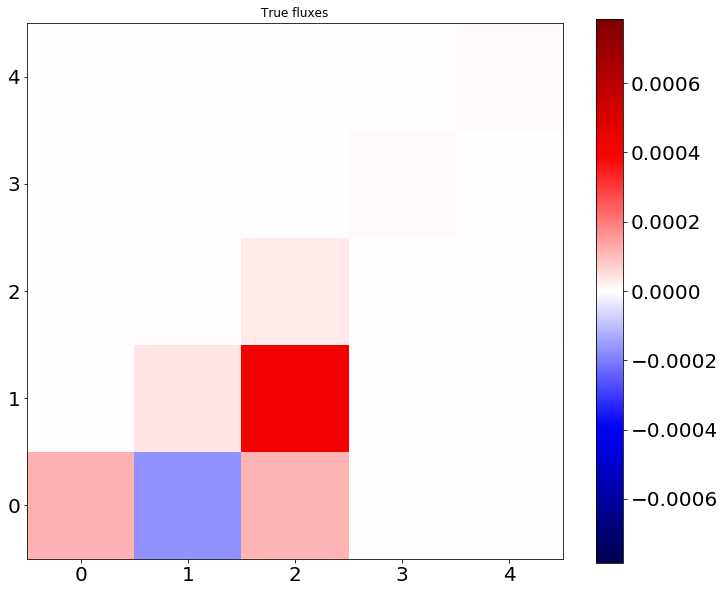

In [23]:
plt.figure(figsize = (12,10))
plt.title('Scarlet fluxess')
plt.imshow((s_matrix), cmap = 'seismic', origin = 'lower', vmin = -np.max(g_matrix), vmax = np.max(g_matrix))
plt.xticks(np.arange(np.size(surveys)), names)
plt.yticks(np.arange(np.size(surveys)), names)
plt.colorbar()
plt.show()

plt.figure(figsize = (12,10))
plt.title('Galsim fluxes')
plt.imshow(g_matrix, cmap = 'seismic', origin = 'lower', vmin = -np.max(g_matrix), vmax = np.max(g_matrix))
plt.xticks(np.arange(np.size(surveys)), names)
plt.yticks(np.arange(np.size(surveys)), names)
plt.colorbar()
plt.show()

plt.figure(figsize = (12,10))
plt.title('True fluxes')
plt.imshow(g_matrix-s_matrix, cmap = 'seismic', origin = 'lower',  vmin = -np.max(g_matrix), vmax = np.max(g_matrix))
#plt.xticks(np.arange(np.size(surveys)), names)
#plt.yticks(np.arange(np.size(surveys)), names)
plt.colorbar()
plt.show()

0 0
0 1
0 2
0 3
0 4


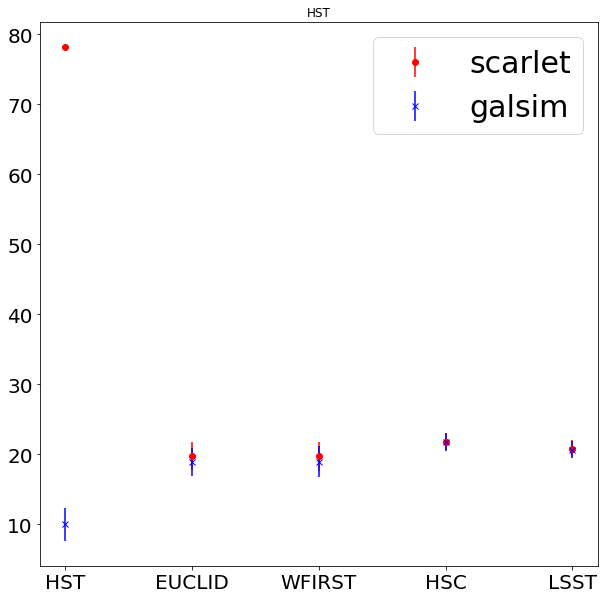

1 1
1 2
1 3
1 4


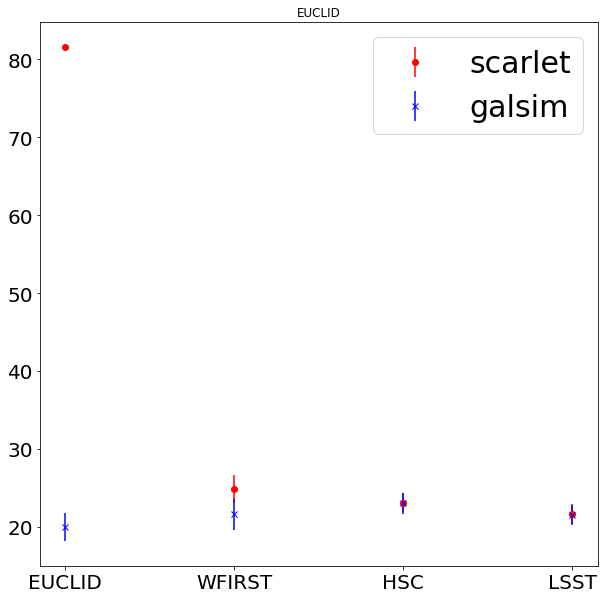

2 2
2 3
2 4


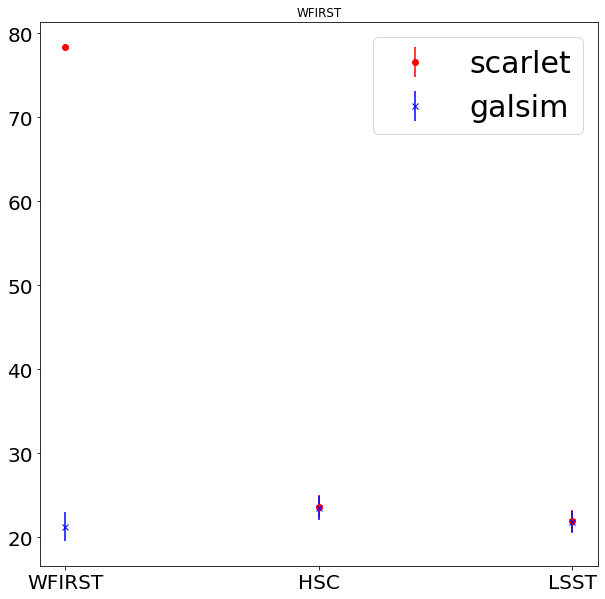

3 3
3 4


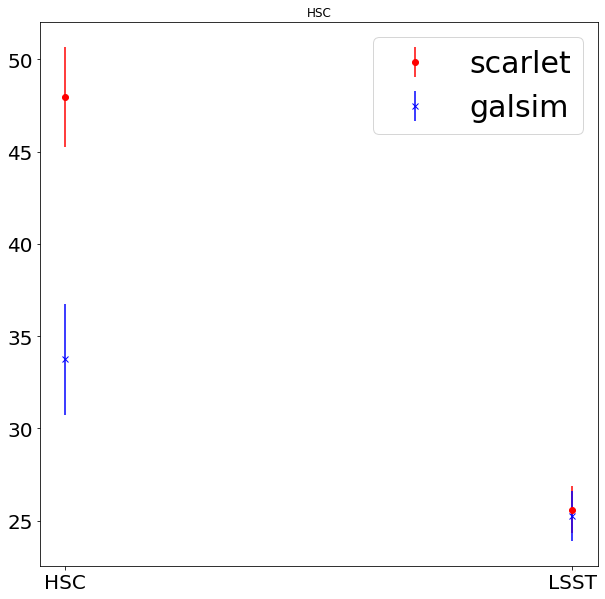

4 4


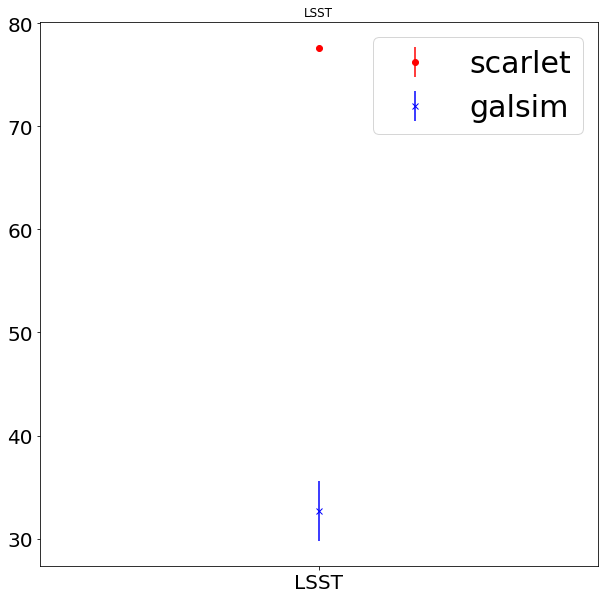

In [6]:
survey_lr = np.array(reconstructions['survey_lr'])
survey_hr = np.array(reconstructions['survey_hr'])
n_hrs = np.array(reconstructions['n_hr'])
s_sdr = np.array(reconstructions['s_sdr'])
g_sdr = np.array(reconstructions['g_sdr'])

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot_sdr(x, condition, label = [None, None]):
    errorbar(x, np.median(s_sdr[condition]), fmt = 'or', label = label[0],
                 yerr = mad(s_sdr[condition]))
    errorbar(x, np.median(g_sdr[condition]), fmt = 'xb', label = label[1],
                 yerr = mad(g_sdr[condition]))
    pass

s_SDRmatrix = np.zeros((np.size(surveys), np.size(surveys)))
g_SDRmatrix = np.zeros((np.size(surveys), np.size(surveys)))
for e, hr in enumerate(surveys):
    figure(figsize = (10,10))
    plt.title(hr['name'])
    for ee, lr in enumerate(surveys[e:]):
        print(e,ee+e)
        s_SDRmatrix[e, ee+e] = np.mean(s_sdr[(survey_hr == hr)*(survey_lr == lr)])
        g_SDRmatrix[e, ee+e] = np.mean(g_sdr[(survey_hr == hr)*(survey_lr == lr)])
        if ee == 0:
            plot_sdr(ee,(survey_hr == hr)*(survey_lr == lr), label = ['scarlet', 'galsim'])
        else:
            plot_sdr(ee,(survey_hr == hr)*(survey_lr == lr))
   
    names = [l['name'] for j,l in enumerate(surveys[e:])]
    plt.xticks((np.arange(ee+1)), names)
    legend(fontsize = 30)
    show()

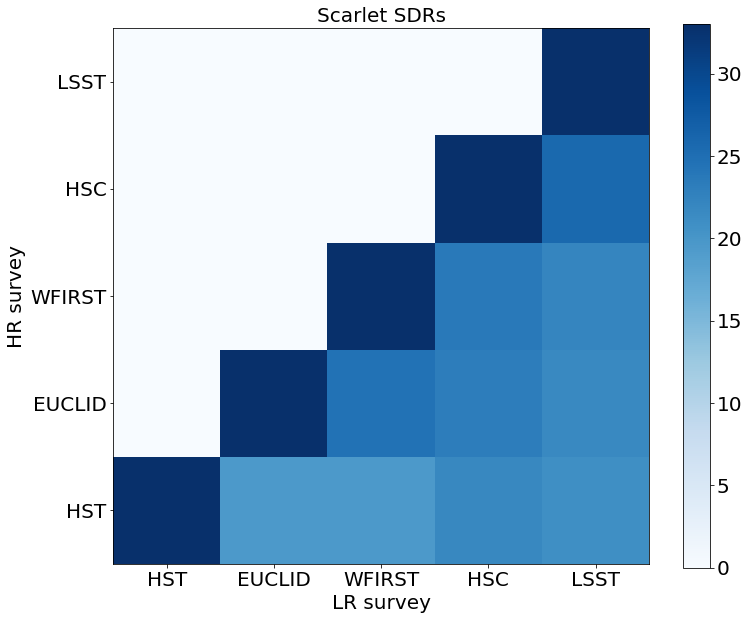

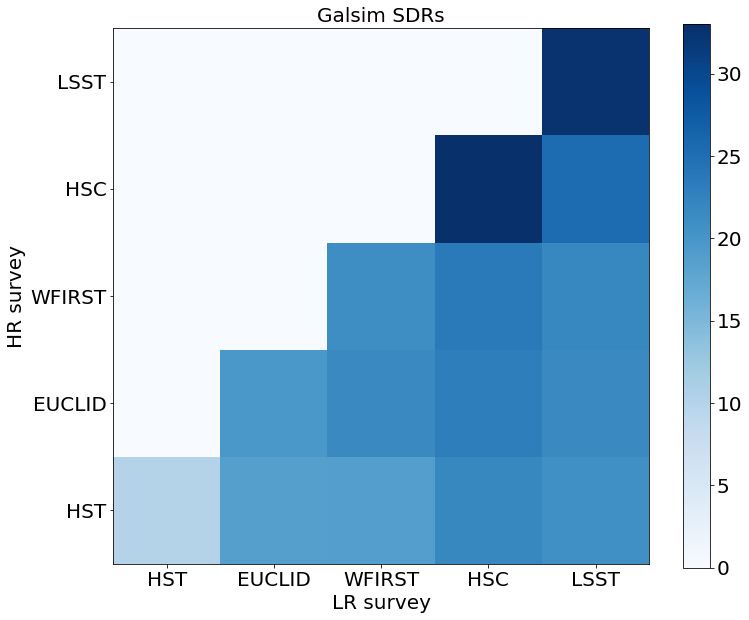

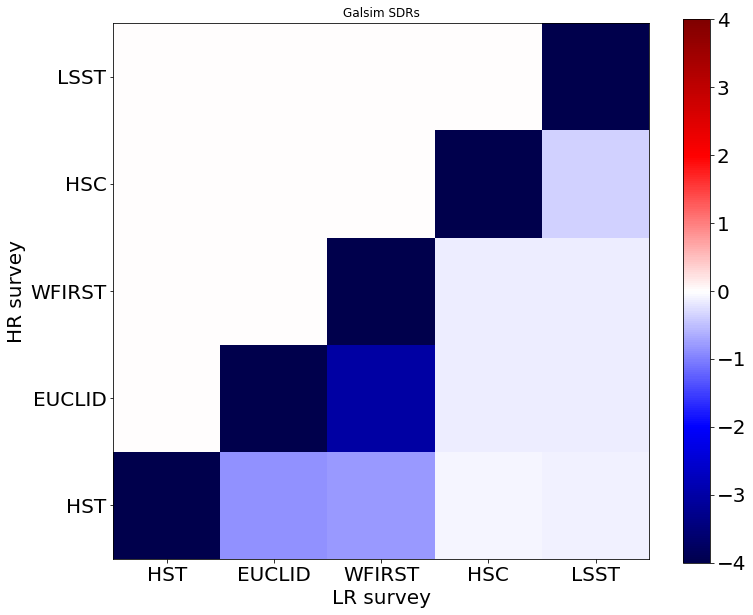

In [7]:
names = [s['name'] for s in surveys]

plt.figure(figsize = (12,10))
plt.title('Scarlet SDRs', fontsize = 20)
plt.imshow((s_SDRmatrix), vmin = np.min(g_SDRmatrix), vmax = np.max(g_SDRmatrix), cmap = 'Blues', origin = 'lower')
plt.xticks(np.arange(np.size(surveys)), names)
plt.yticks(np.arange(np.size(surveys)), names)
plt.ylabel('HR survey', fontsize = 20)
plt.xlabel('LR survey', fontsize = 20)
plt.colorbar()
plt.show()

plt.figure(figsize = (12,10))
plt.title('Galsim SDRs', fontsize = 20)
plt.imshow(g_SDRmatrix, cmap = 'Blues', origin = 'lower')
plt.xticks(np.arange(np.size(surveys)), names)
plt.yticks(np.arange(np.size(surveys)), names)
plt.ylabel('HR survey', fontsize = 20)
plt.xlabel('LR survey', fontsize = 20)
plt.colorbar()
plt.show()

plt.figure(figsize = (12,10))
plt.title('Galsim SDRs')
plt.imshow(g_SDRmatrix-s_SDRmatrix, vmin = -4, vmax = 4, cmap = 'seismic', origin = 'lower')
plt.xticks(np.arange(np.size(surveys)), names)
plt.yticks(np.arange(np.size(surveys)), names)
plt.ylabel('HR survey', fontsize = 20)
plt.xlabel('LR survey', fontsize = 20)
plt.colorbar()
plt.show()